In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
# import scienceplots
from scipy.stats import bootstrap

# plt.style.use(['science','nature'])
plt.style.use(['./nature.mplstyle'])
sns.set_palette('tab10', n_colors=3)
colors = ["#7eb0d5", "#fd7f6f", "#b2e061", "#bd7ebe", "#ffb55a", "#ffee65", "#beb9db", "#fdcce5", "#8bd3c7"]
sns.set_palette(colors, n_colors=3)


I’m attaching the different pickle files with all the variables. The analytical model has no uncertainty, so the content is:
 
data = {"x":x, "remix":remix, "expert":expert, "discuss":discuss}
 
where the x is the number of people and the others are the y of each case (i.e. the utility value)
 
The other cases are slightly more complex, since re-run for the same value of can produce different results. So in this case you have
 
    data = {"x":x,
        'remixing_raw': remixing_raw,
        'expert_raw': expert_raw,
        'deliberation_raw': deliberation_raw,
       
        'remixing_results': remixing_results,
        'expert_results': expert_results,
        'deliberation_results': deliberation_results,
       
        'remixing_std': remixing_std,
        'expert_std': expert_std,
        'deliberation_std': deliberation_std
    }
 
The "_results" are the mean value, while the “_std” are the respective standard deviations. For example to plot the remixing case you can use:
 
plt.plot(x, remixing_results, label='Remixing')
plt.fill_between(x, np.array(remixing_results) - remixing_std, np.array(remixing_results) + remixing_std, alpha=0.2)
 
The “_raw” are the original data and they are list of lists. Each sub-list is the series of values obtained for the respective values of x. For example, you could get the _results as
 
remixing_results = [np.mean(el) for el in remixing_raw]

In [2]:
with open('data/analytical_model.pkl', 'rb') as f:
    data = pickle.load(f)

In [3]:
analytical_df = pd.DataFrame(pd.read_pickle('data/analytical_model.pkl'))
analytical_df = analytical_df.melt(id_vars=['x'], var_name='method', value_name='utility')
analytical_df['method'] = analytical_df.method.map({'remix': 'remixing', 'expert': "crowdsourcing", 'discuss': 'deliberation'})

In [4]:
# import glob
# {i.split('_')[-1].split('.pkl')[0]: i for i in glob.glob('data/sim*.pkl')}

datasets = {'Beta': 'data/sim_Beta.pkl',
         'Binomial': 'data/sim_Binomial.pkl',
         'Chisquare': 'data/sim_Chisquare.pkl',
         'Exponential': 'data/sim_Exponential.pkl',
         'Gamma': 'data/sim_Gamma.pkl',
         'Laplace': 'data/sim_Laplace.pkl',
         'Normal': 'data/sim_Normal.pkl',
         'Uniform': 'data/sim_Uniform.pkl',
         'Weibull': 'data/sim_Weibull.pkl'}


_dfs_to_combine = []
for k, v in datasets.items():
    _df = pd.DataFrame(pd.read_pickle(v))
    _df['distribution'] = k
    _dfs_to_combine.append(_df)

df = pd.concat(_dfs_to_combine).reset_index(drop=True)
df['trial_id'] = df.remixing_raw.apply(lambda x: list(range(len(x))))

In [5]:
explode_cols = ['remixing_raw',	'expert_raw', 'deliberation_raw', 'trial_id']
cols_to_keep = ['x', 'distribution'] + explode_cols

In [6]:
s = df.explode(explode_cols).reset_index(drop=True)

In [7]:
# pd.wide_to_long(s[cols_to_keep], stubnames='_raw', i=['x', 'distribution','trial_id'], j='method')
final_df = pd.melt(s[cols_to_keep], id_vars=['x', 'distribution','trial_id'], var_name='method', value_name='utility')
final_df['method'] = final_df['method'].str.split('_').str[0]

final_df['method'] = final_df.method.map({'remixing': 'remixing', 'expert': "crowdsourcing", 'deliberation': 'deliberation'})

In [8]:
analytical_df.method.unique()

array(['remixing', 'crowdsourcing', 'deliberation'], dtype=object)

In [9]:
# data = {"x":N_agents_vec,
#         'remixing_raw': final_result,
#         'remixing_results': [np.mean(el) for el in final_result],
#         'remixing_std': [np.std(el) for el in final_result],
#     }

abm_df = pd.DataFrame(pd.read_pickle('data/abm_dino_4.pkl'))
abm_df = abm_df.explode('remixing_raw').reset_index(drop=True)
abm_df = pd.melt(abm_df[['x', 'remixing_raw']], id_vars=['x'], var_name='method', value_name='utility')
abm_df['method'] = 'M1'
abm_df['utility'] /= abm_df['utility'].max()

seraina_abm_df = pd.read_csv('data/50reps_10-10000as.csv')
seraina_abm_df['x'] = seraina_abm_df['number of agents']
seraina_abm_df['method'] = 'M2'
seraina_abm_df['utility'] = seraina_abm_df['average utility of voted design'] 

cesare_abm_df = pd.read_csv('data/results_N10000_2d_T1_S10_M1_K3_deepseekmodel.csv')
# cesare_abm_df.iloc[:, 1:].to_csv('data/results_N10000_2d_T1_S10_M1_K3_deepseekmodel.csv', index=False)
cesare_abm_df = cesare_abm_df.rename(columns={"N": "x", "utility": "utility_raw", "utility_ratio": "utility"})
cesare_abm_df['method'] = 'M3'

abm_df = pd.concat([abm_df, seraina_abm_df, cesare_abm_df], ignore_index=True)

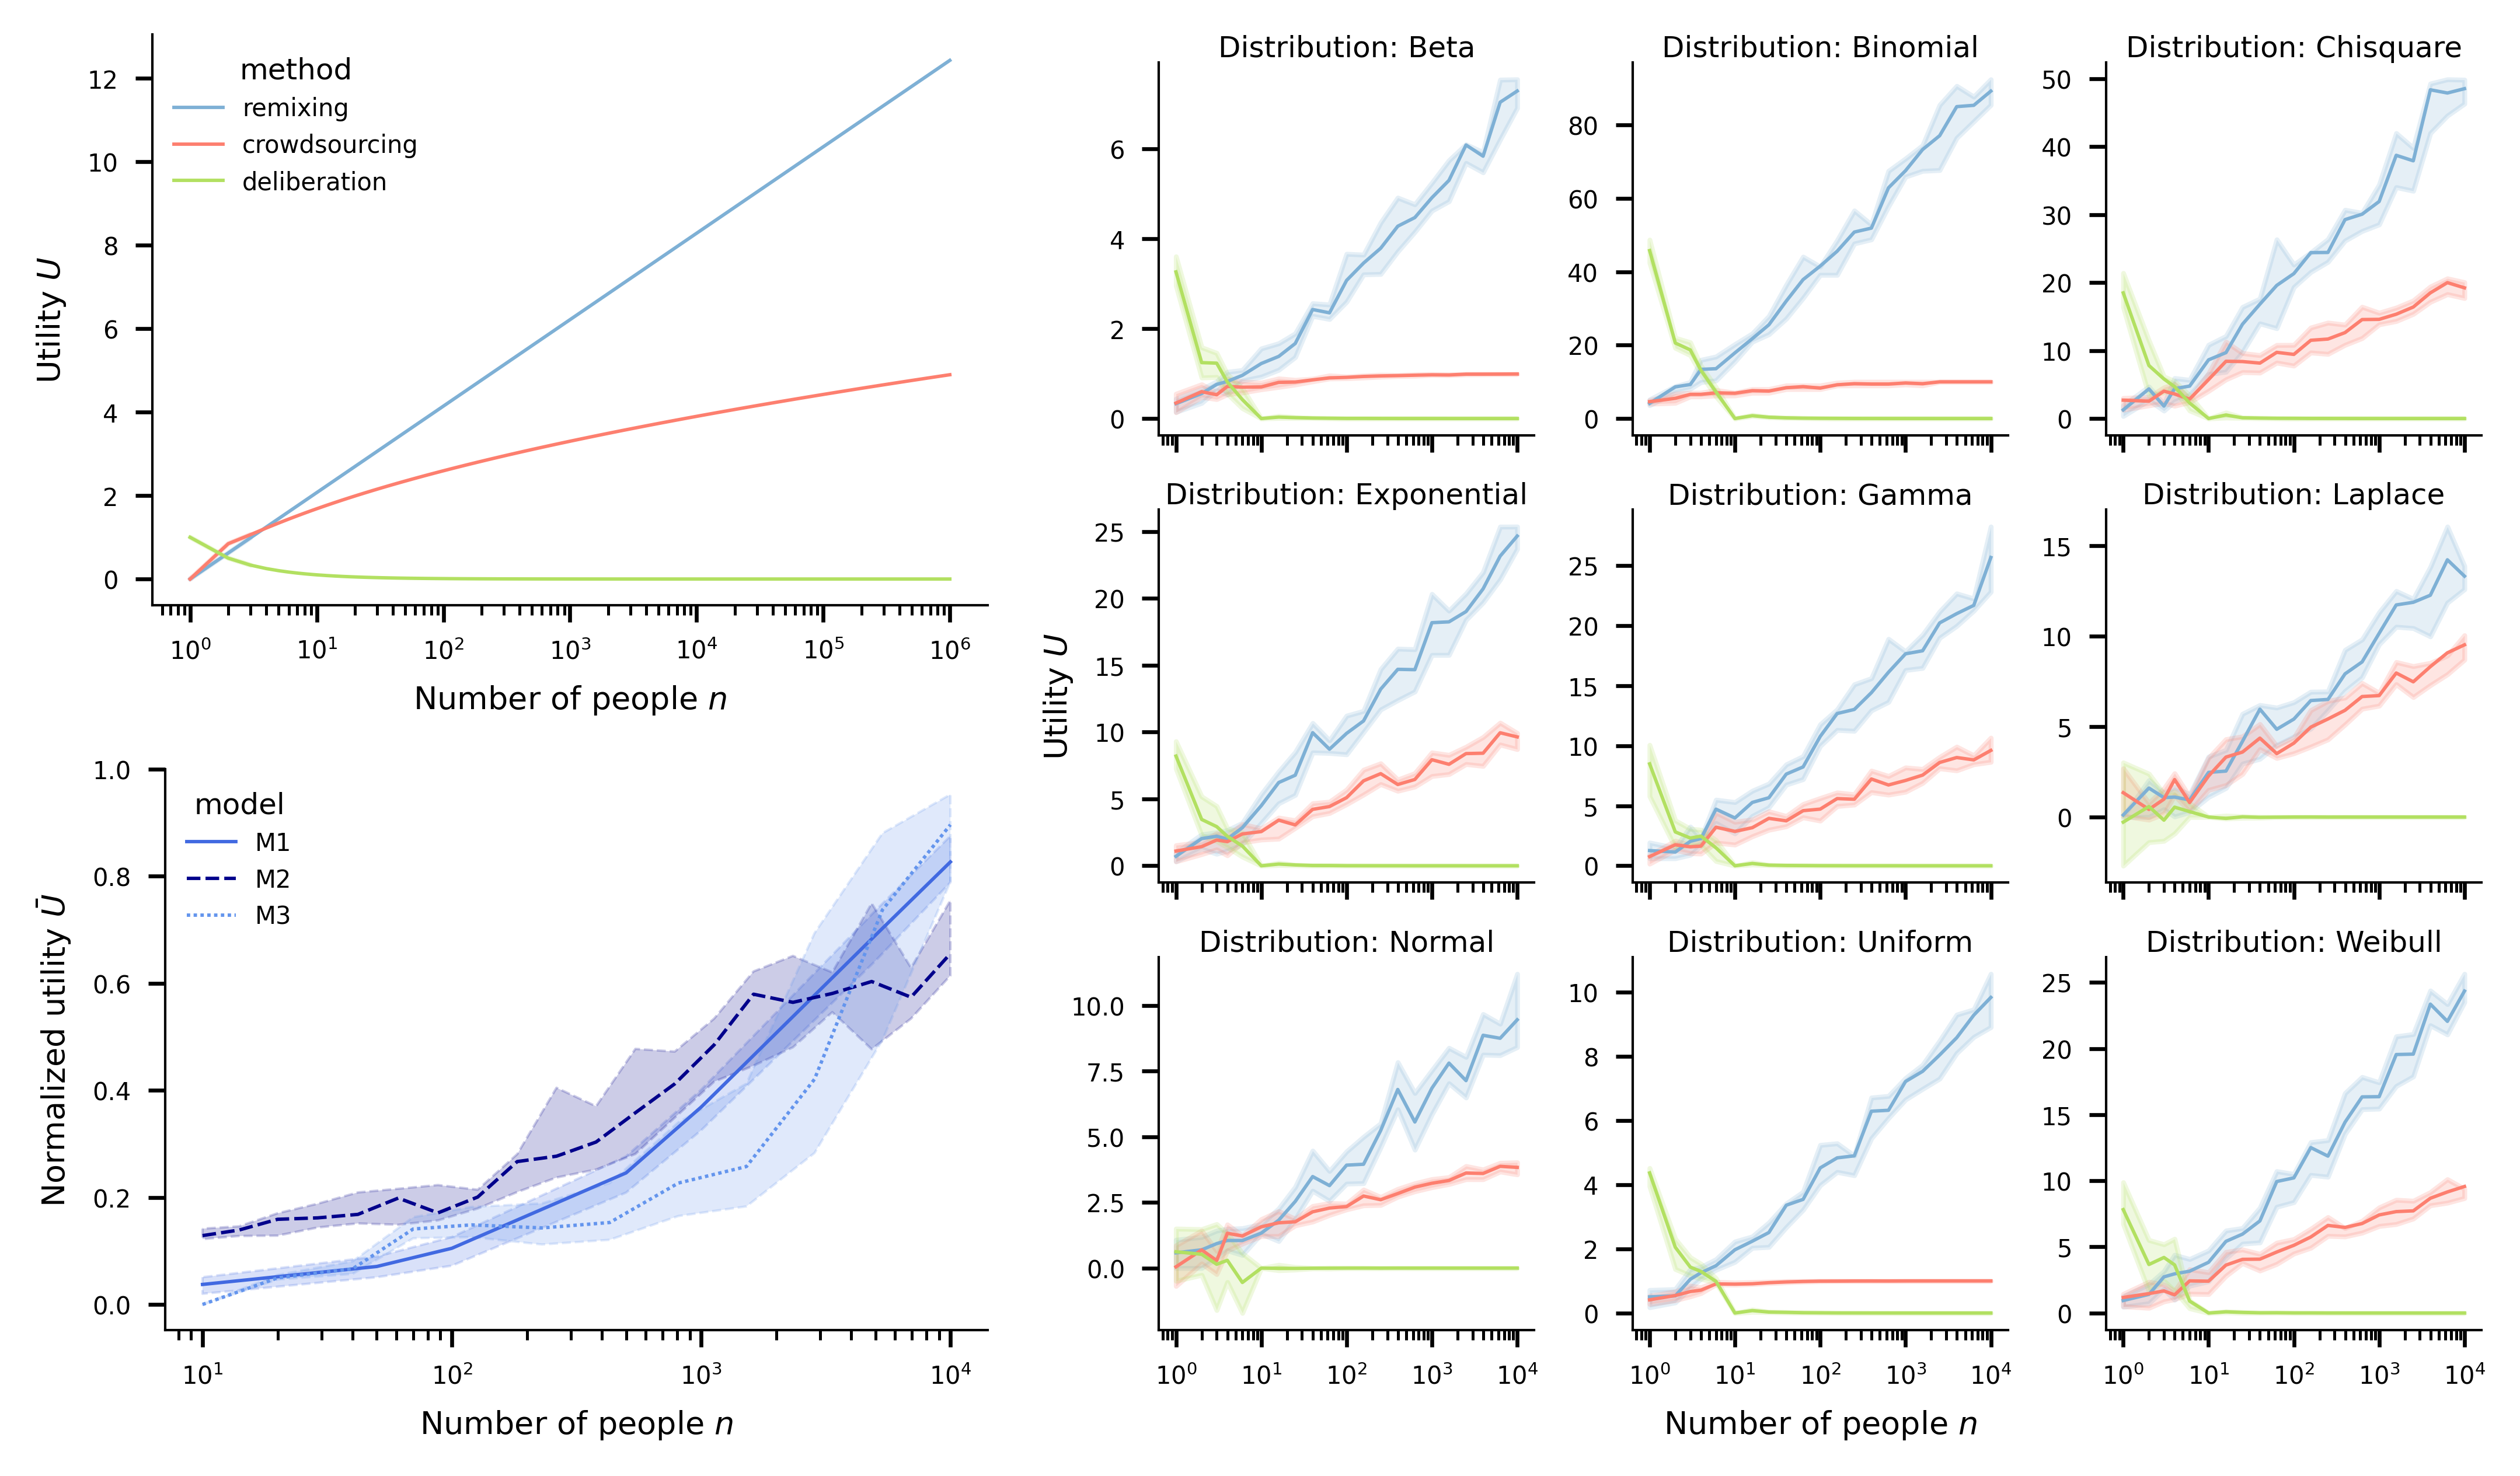

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Create the full figure
fig = plt.figure(figsize=(7.08, 4.1), constrained_layout=True)

hue_order = ["remixing", "crowdsourcing", "deliberation"]
# Step 2: Create two vertical subfigures: top for the regular plot and facet grid, bottom for ABM

# --- Top subfigure split horizontally: regular + small facets ---
subfig_left, subfig_right = fig.subfigures(1, 2, width_ratios=[2, 3])
subfig_top, subfig_bottom = subfig_left.subfigures(2, 1, height_ratios=[1, 1])

# Regular seaborn plot (left side)
ax_main = subfig_top.subplots(1, 1)
sns.lineplot(data=analytical_df, x='x', y='utility', hue='method', ax=ax_main,
             hue_order=hue_order, errorbar=('pi', 50))
ax_main.set_xscale('log')
ax_main.set_xlabel(r"Number of people $n$", in_layout=True)
ax_main.set_ylabel(r"Utility $U$")

# Small multiples (right side)
num_dists = len(final_df.distribution.unique())
ncols = 3
nrows = (num_dists + ncols - 1) // ncols
axes_facets = subfig_right.subplots(nrows, ncols, sharex='col')
axes_facets = axes_facets.flatten()

ref_ax = None
for i, (distribution, ax) in enumerate(zip(final_df.distribution.unique(), axes_facets)):
    subset = final_df.query('distribution==@distribution')
    sns.lineplot(data=subset, x='x', y='utility', hue='method', errorbar=('pi', 50), ax=ax,
                #  hue_order=["remixing", "expert", "deliberation"],
                 hue_order=hue_order,
                 legend=False)
    ax.set_title(f"Distribution: {distribution}", pad=-5)
    ax.set_xscale("log")
    ax.set_xlabel("")
    ax.set_ylabel("")
    
    row_idx = i // ncols
    col_idx = i % ncols

    if row_idx < nrows - 1:
        ax.tick_params(labelbottom=False)
    elif col_idx == 1:
        ax.set_xlabel(r"Number of people $n$")

    if col_idx == 0 and row_idx == 1:
        ax.set_ylabel(r"Utility $U$")

# Hide unused facet axes if any
for j in range(i + 1, len(axes_facets)):
    fig.delaxes(axes_facets[j])

# --- Bottom subfigure for ABM plot ---
ax_abms = subfig_bottom.subplots(1, 1)
palette = ["royalblue", "darkblue", "cornflowerblue"]
g = sns.lineplot(data=abm_df, x='x', y='utility', hue='method', style='method',
                 errorbar=('pi', 50), estimator='median', ax=ax_abms,
                 legend=True, palette=palette, err_kws={'linestyle': '--', 'linewidth': 0.5, 'alpha': 0.2})
ax_abms.set_xscale('log')
ax_abms.set_xlabel(r"Number of people $n$")
ax_abms.set_ylabel(r"Normalized utility $\bar{U}$")
g.legend_.set_title("model")

sns.despine()

In [11]:
fig.savefig("models.pdf", dpi=600, bbox_inches='tight')


In [12]:
axs

NameError: name 'axs' is not defined

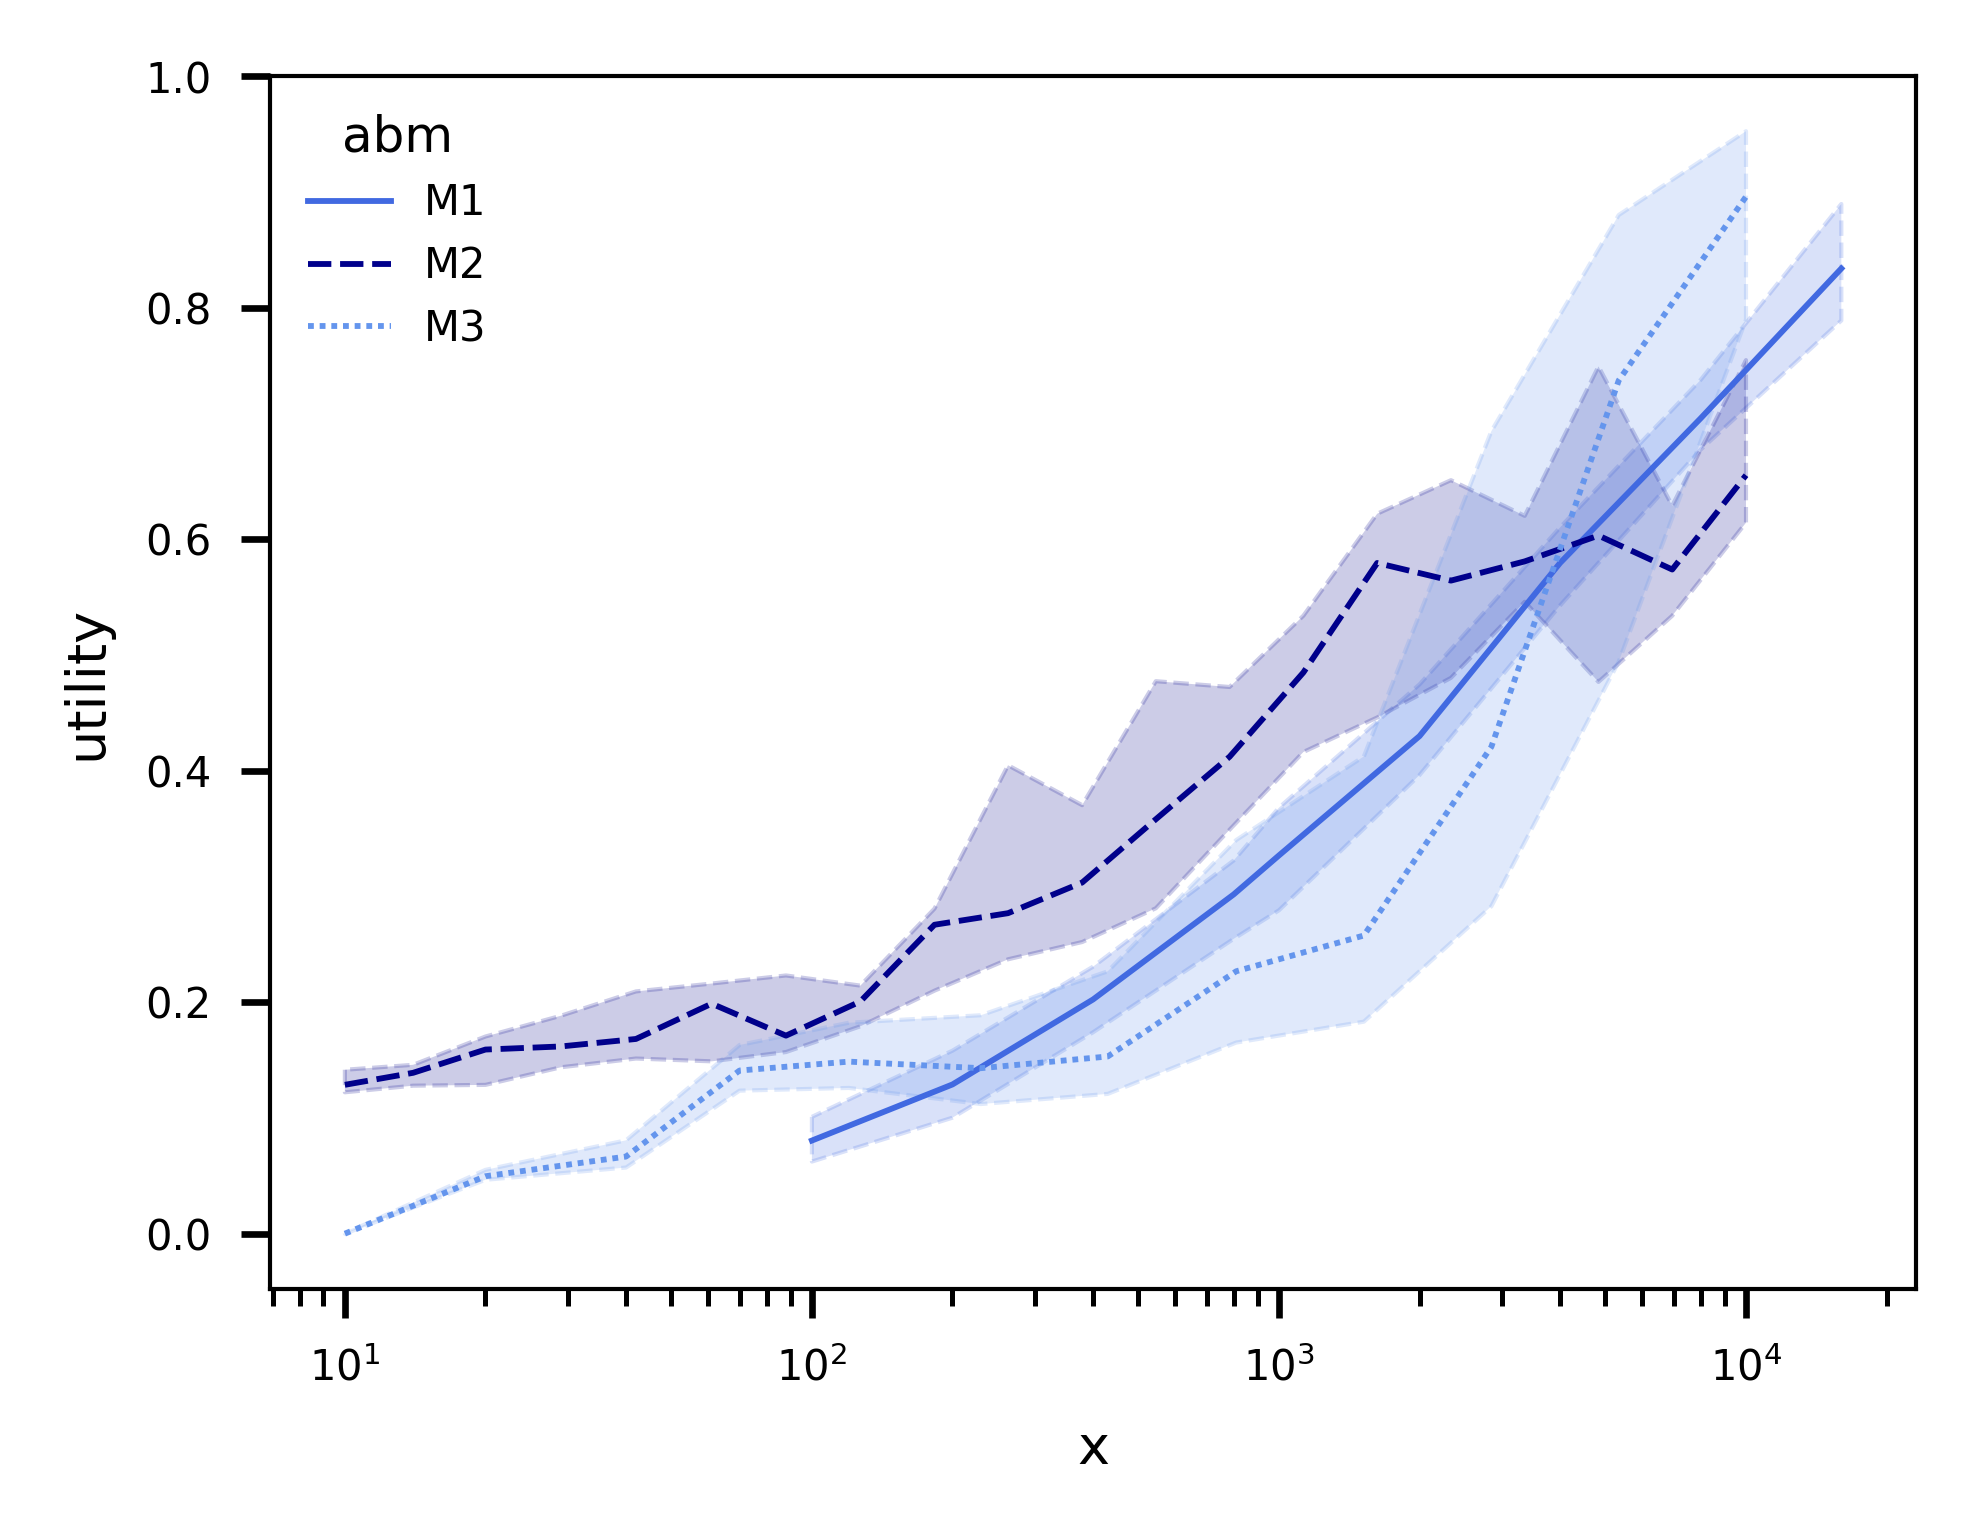

In [ ]:
fig, ax = plt.subplots(1)

palette = "Blues_r"
palette = ["royalblue", "darkblue", "cornflowerblue"]
g = sns.lineplot(data=abm_df, x='x', y='utility', hue='method', style='method', errorbar=('pi', 50), estimator='median', ax=ax,
             legend=True, palette=palette, err_kws={'linestyle': '--', 'linewidth': 0.5, 'alpha': 0.2})
ax.set_xscale('log')
g.legend_.set_title("abm")


In [ ]:
import matplotlib as mpl
mpl.__version__

'3.9.1'